This file is created as a trial of sparsity on a regression example. <br>
We consider a dataset with p features and n sample. Dataset is generated over a normal distribution with $\mu=0$ and $\sigma^2=1$ or <br>
$X=\mathcal{N}(\mu, \sigma^2)$.<br>
The output is also generated based on a linear function including a noise term as follows <br>
$y=X\beta+n(0,1)$. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

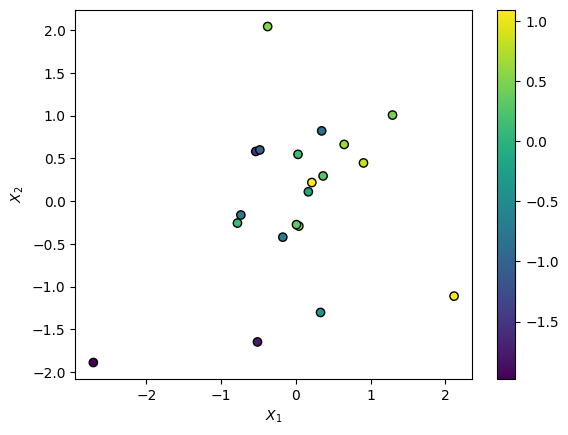

In [24]:
RNG = np.random.default_rng(seed=1)
p = 2
n = 20
var = 1
cov = var*np.eye(p)
mean = np.zeros(p)
sigma = 1

# To define the weights as beta
beta = np.array([1, 0]) 

# To define the features/inputs and labels/outputs
x = RNG.multivariate_normal(mean, cov, size=n)
y = x@beta + RNG.normal(0, sigma**2, size=n)

# To show the dataset
plt.scatter(x[:, 0], x[:, 1], c=y, edgecolors='black')
plt.xlabel("$X_1$")
plt.ylabel("$X_2$")
plt.colorbar()
plt.show()

The loss function also is defined as a squared norm of residuals as follows <br>
$loss=\vert\vert X\beta - Y\vert\vert ^2$

In [87]:
# To define the loss function
# def squared_error(beta):
#     return np.linalg.norm(x.dot(np.atleast_2d(beta).T) - y.reshape(-1, 1), axis=0)**2

# To define another form of loss function
def squared_error(beta):
    return np.sum(abs(x@beta-y)**2)

In [89]:
# To check the loss function
# squared_error(beta)

Then we define a space of 2 dimensions for all probable $\beta$  and calculate the loss function for this space.

In [37]:
# To define the estimation space of beta
_beta1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[0]
_beta2 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))[1]
_beta = np.dstack((_beta1, _beta2))
_beta.shape
# _beta

(100, 100, 2)

In [36]:
squared_error(_beta)

ValueError: shapes (20,2) and (2,100,100) not aligned: 2 (dim 1) != 100 (dim 1)

In [186]:
beta_hat = np.linalg.solve(x.T.dot(x), x.T.dot(y))
beta_hat

array([0.62441303, 0.20780253])

In [172]:
from numpy.linalg import norm

alpha=1.0

def regularised_error(beta):
    return squared_error(beta) + alpha*norm(np.atleast_2d(beta), 1, axis=1)

squared_error(_beta), regularised_error(_beta)

(array([266.8733238 , 262.37703272, 257.93721797, ..., 114.64624143,
        117.1792949 , 119.76882472]),
 array([270.8733238 , 266.33662867, 261.85640989, ..., 118.56543334,
        121.13889086, 123.76882472]))

ValueError: cannot reshape array of size 200 into shape (100,100)

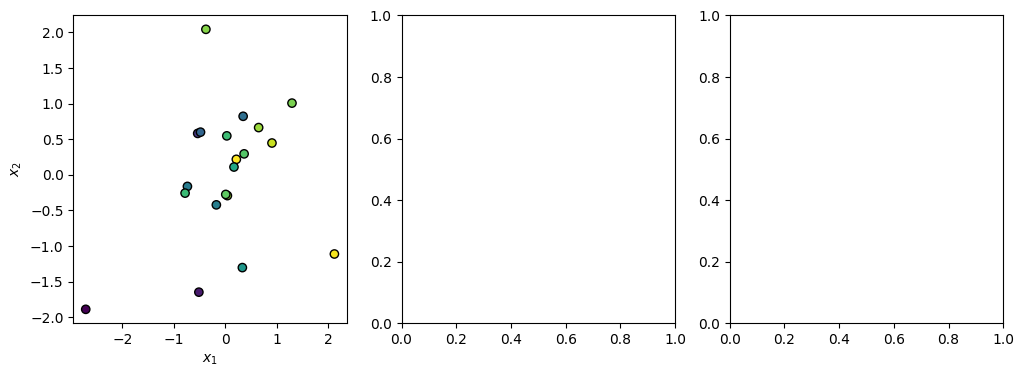

In [208]:
from matplotlib import pyplot as plt

_, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].scatter(x[:, 0], x[:, 1], c=y, edgecolors='black')
axs[0].set_xlabel('$x_1$')
axs[0].set_ylabel('$x_2$')
# axs[1].contourf(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), errors.reshape(100, 100), levels=50, cmap='Reds')
# axs[1].contour(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), errors.reshape(100, 100), levels=200, color='black')
# axs[1].scatter(beta[0], beta[1], marker='*', color='black')
# axs[1].scatter(beta_hat[0], beta_hat[1], marker='x', color='black')

axs[2].contourf(_beta[:, 0].reshape(100, 100), _beta[:, 1].reshape(100, 100), regularised_error(_beta).reshape(100, 100), levels=50, cmap='Reds')

plt.show()

In [192]:
squared_error(_beta[np.argmin(errors)])

array([9.12832593])

In [193]:
squared_error(beta_hat)

array([7.83167108])